# T-SNE 

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, size, explode, regexp_replace, when, collect_list, expr, udf
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, FloatType
from sentence_transformers import SentenceTransformer
from pyspark.ml.feature import VectorAssembler
import numpy as np
from scipy.spatial.distance import cosine
import re
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from matplotlib import cm
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.functions import array_to_vector
from pyspark.ml.linalg import Vectors

In [0]:
N = 20_000
index = 0

In [0]:
file_path = f"dbfs:/FileStore/tables/dvirPeleg/people_new_misc_model_index_{index}_N_{N}"
people_df = spark.read.format("parquet").load(file_path)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f30586fbba0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/root/.ipykernel/1727/command-9006594411633554-237302202:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = {industry: cm.get_cmap('tab10')(i % 10) for i, industry in enumerate(industry_categories)}


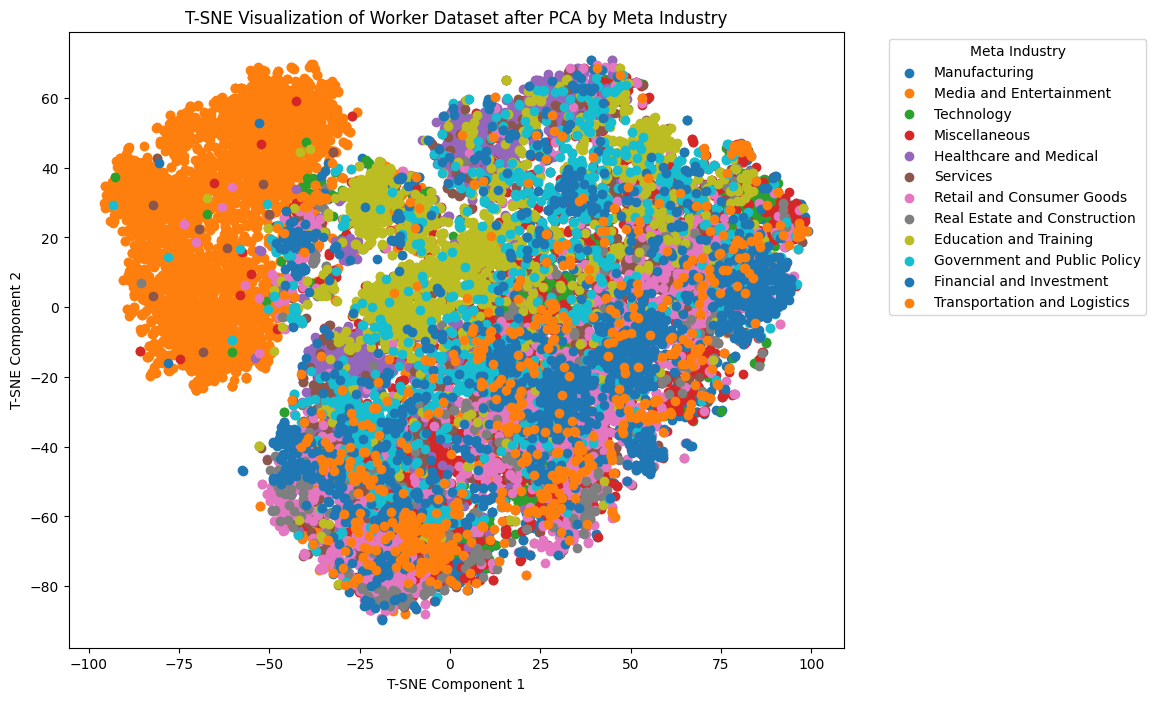

In [0]:
# PCA:
people_features = people_df.withColumn("features", array_to_vector("summary_emb")) # this df will be used in the summary part

K=20
pca = PCA(k=K, inputCol="features", outputCol="pca_features")
pipeline = Pipeline(stages=[pca])
model = pipeline.fit(people_features)
people_features_pca = model.transform(people_features)


# TSNE:
pca_df = people_features_pca.select("id", "meta_industry", "pca_features").toPandas()
X = np.array(pca_df['pca_features'].apply(lambda x: np.array(x.toArray())).tolist())

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, perplexity=20)
X_tsne = tsne.fit_transform(X)
pca_df['TSNE_1'] = X_tsne[:, 0]
pca_df['TSNE_2'] = X_tsne[:, 1]

industry_categories = pca_df['meta_industry'].unique()
color_map = {industry: cm.get_cmap('tab10')(i % 10) for i, industry in enumerate(industry_categories)}

plt.figure(figsize=(10, 8))

for industry in industry_categories:
    subset = pca_df[pca_df['meta_industry'] == industry]
    plt.scatter(subset['TSNE_1'], subset['TSNE_2'], label=industry, color=color_map[industry])

plt.title("T-SNE Visualization of Worker Dataset after PCA by Meta Industry")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(title="Meta Industry", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
